In [224]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime
import seaborn as sns
import pyfolio as pf
from WindPy import w
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

In [236]:
sns.set(style="darkgrid")

In [154]:
w.start()

.ErrorCode=0
.Data=[Already conntected!]

# 读取数据

### 通过wind接口读取

In [413]:
# contract = "IF00.CFE" # 沪深300期货当月
# contract = "CU01.SHF" # 沪铜连三
# contract = "A01.DCE"
contract = "JD01.DCE"

In [414]:
raw = w.wsd(contract, "close", beginTime="2002-01-01", endTime="2017-01-17")

In [415]:
raw

.ErrorCode=0
.Codes=[JD01.DCE]
.Fields=[CLOSE]
.Times=[20020104,20020107,20020108,20020109,20020110,20020111,20020114,20020115,20020116,20020117,...]
.Data=[[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...]]

In [416]:
dic = {}
for data, field in zip(raw.Data, raw.Fields):
    dic[str.lower(str(field))] = data

In [417]:
df = pd.DataFrame(dic, index=raw.Times)

In [418]:
raw_df = df.copy().dropna()

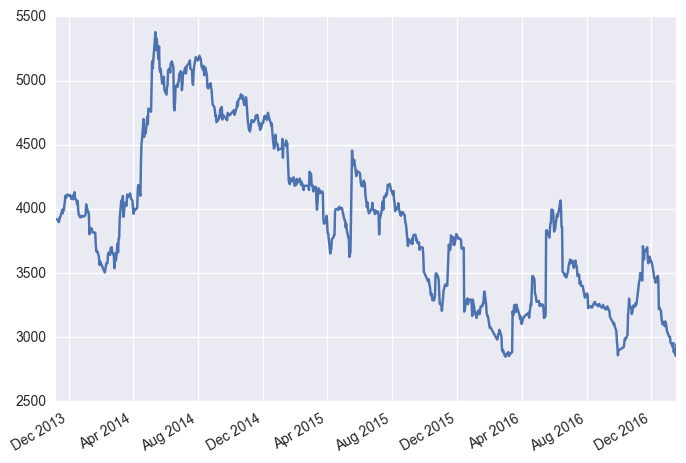

In [419]:
raw_df["close"].plot()

# 提取每日收益

In [420]:
def daily_return(df):
    df[contract] = df["close"].pct_change()
    return df[contract]

In [421]:
day_return = daily_return(df)

In [422]:
day_return.dropna(inplace=True)

In [423]:
day_return.head()

2013-11-11 00:00:00.005   -0.002041
2013-11-12 00:00:00.005   -0.003579
2013-11-13 00:00:00.005   -0.000257
2013-11-14 00:00:00.005    0.009751
2013-11-15 00:00:00.005   -0.000254
Name: JD01.DCE, dtype: float64

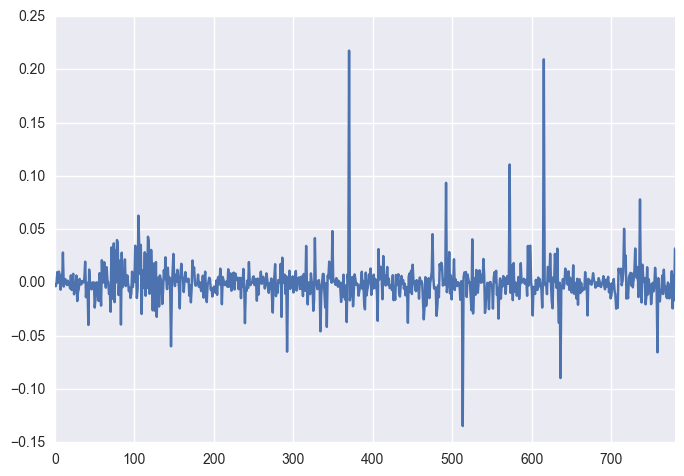

In [424]:
sns.tsplot(day_return)

# 计算波动率
$$\sigma^2_t=261\sum^\infty_{i=0}(1-\delta)\delta^i(r_{t-1-i}-\bar{r}_t)^2$$

In [425]:
day_vol = day_return.ewm(ignore_na=False, adjust=True, com=60, min_periods=0).std(bias=False)

In [426]:
vol = day_vol * np.sqrt(261) # annualise

# 计算Time Series Momentum (TSMOM)
$$TSMOM_{t+1}^{X-month} = \text{sign(excess return of s over past X month)} \frac{40%}{\sigma_t^s}r_{t+1}^s$$


### 提取monthly return和volatility

In [427]:
std_index = day_return.resample("BM").last() # month index

In [428]:
ret_index = (1 + day_return).cumprod()

In [429]:
ret_index[0] = 1

In [430]:
ret_index = pd.concat([ret_index, vol], axis=1)
ret_index.columns = [contract, "%s_vol"%(contract)]

In [431]:
ret_m_index = ret_index.resample('BM').last().ffill()

In [432]:
ret_m_index.ix[0][contract] = 1

In [433]:
ret_m_index.head()

,JD01.DCE,JD01.DCE_vol
2013-11-29,1.000000,0.138048
2013-12-31,1.005612,0.120071
2014-01-31,0.913776,0.166436
2014-02-28,0.917602,0.199064
2014-03-31,1.036480,0.253452


### (Short/Medium/Long Term) TSMOM Strategy

In [434]:
target_vol = 0.4
look_back = 6

In [435]:
std_index = ret_m_index.index
pnl = pd.DataFrame(index=std_index)
leverage = pd.DataFrame(index=std_index)

In [436]:
df = ret_m_index.copy()

In [437]:
df["return"] = df[contract].pct_change(look_back)
df["pnl"] = 0.0
df["leverage"] = 0.0
long_markers = []
short_markers = []
for k, v in enumerate(df["return"]):
    if k <= look_back:
        continue
    if df["return"].iloc[k - 1] < 0:
        df["pnl"].iloc[k] = (df[contract].iloc[k - 1] / df[contract].iloc[k] - 1) *\
                            target_vol / df["%s_vol"%(contract)].iloc[k - 1]
        df["leverage"].iloc[k] = target_vol / df["%s_vol"%(contract)].iloc[k - 1]
        short_markers.append(df.index[k - 1])
        print("%s: short %.2f%% shares, return: %.2f"%
              (df.index[k - 1].strftime("%Y-%m-%d"), target_vol / df["%s_vol"%(contract)].iloc[k - 1], df["pnl"].iloc[k]))
    else:
        df["pnl"].iloc[k] = (df[contract].iloc[k] / df[contract].iloc[k - 1] - 1) *\
                            target_vol / df["%s_vol"%(contract)].iloc[k - 1]
        df["leverage"].iloc[k] = target_vol / df["%s_vol"%(contract)].iloc[k - 1]
        long_markers.append(df.index[k - 1])
        print("%s: long %.2f%% shares, return: %.2f"%
              (df.index[k - 1].strftime("%Y-%m-%d"), target_vol / df["%s_vol"%(contract)].iloc[k - 1], df["pnl"].iloc[k]))
    # print k, df["pnl"].iloc[k]
pnl = pd.concat([pnl, df["pnl"]], axis=1)
leverage = pd.concat([leverage, df["leverage"]], axis=1)

2014-05-30: long 1.30% shares, return: 0.04
2014-06-30: long 1.34% shares, return: 0.02
2014-07-31: long 1.53% shares, return: -0.10
2014-08-29: long 1.73% shares, return: -0.03
2014-09-30: long 1.95% shares, return: 0.06
2014-10-31: long 2.16% shares, return: -0.10
2014-11-28: short 2.20% shares, return: 0.08
2014-12-31: short 2.30% shares, return: 0.16
2015-01-30: short 1.88% shares, return: -0.05
2015-02-27: short 1.93% shares, return: 0.17
2015-03-31: short 1.77% shares, return: -0.02
2015-04-30: short 1.71% shares, return: -0.12
2015-05-29: short 0.84% shares, return: 0.07
2015-06-30: short 0.97% shares, return: -0.04
2015-07-31: short 1.11% shares, return: 0.13
2015-08-31: short 1.25% shares, return: 0.07
2015-09-30: short 1.39% shares, return: 0.11
2015-10-30: short 1.40% shares, return: -0.20
2015-11-30: short 1.25% shares, return: 0.19
2015-12-31: short 1.04% shares, return: 0.05
2016-01-29: short 1.16% shares, return: 0.12
2016-02-29: short 1.26% shares, return: -0.10
2016-03

In [438]:
print("Sharpe Ratio = " + str(pf.empyrical.sharpe_ratio(df["pnl"], period="monthly")))

Sharpe Ratio = 0.337549626522


In [439]:
print("Max Drawdown = " + str(pf.empyrical.max_drawdown(df["pnl"])))

Max Drawdown = -0.444489390843


# plot

In [440]:
raw_df["value"] = raw_df["close"].pct_change()

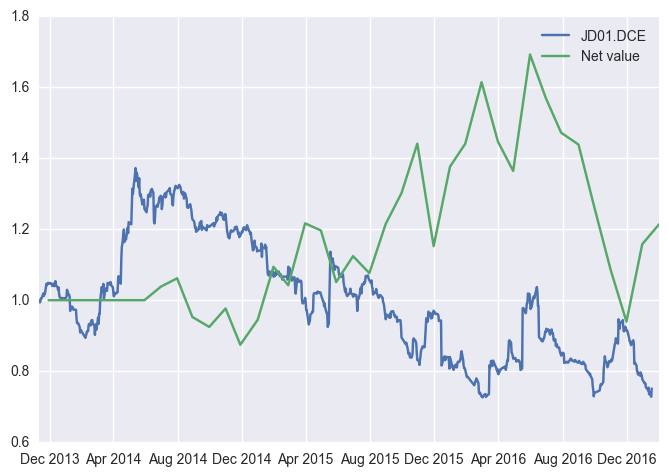

In [441]:
plt.plot((1 + raw_df["value"]).index, (1 + raw_df["value"]).cumprod(), label=contract)
plt.plot((1 + df["pnl"]).index, (1 + df["pnl"]).cumprod(), label='Net value')
plt.legend()

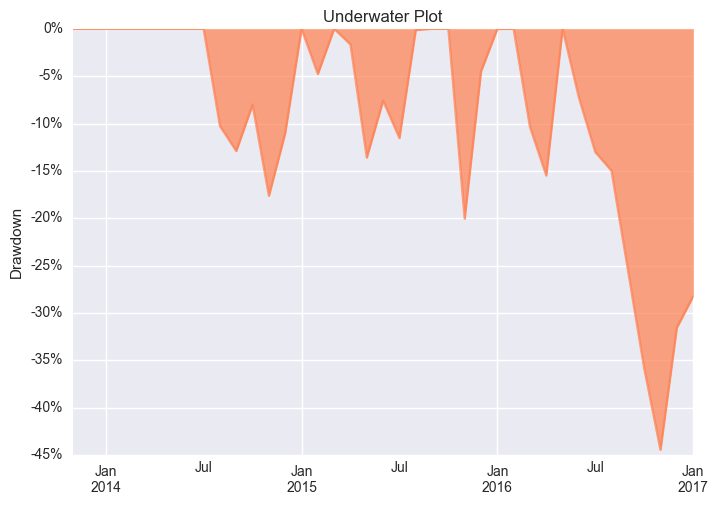

In [442]:
pf.plot_drawdown_underwater(df["pnl"])

In [450]:
benchmark_total_return = ret_m_index[contract].ix[-1]
benchmark_annual_return = pf.empyrical.annual_return(ret_m_index[contract].pct_change(), period="monthly")
benchmark_sharpe = pf.empyrical.sharpe_ratio(ret_m_index[contract].pct_change(), period="monthly")
benchmark_max_drawdown = pf.empyrical.max_drawdown(ret_m_index[contract].pct_change())

In [446]:
sharpe = pf.empyrical.sharpe_ratio(df["pnl"], period="monthly")
max_drawdown = pf.empyrical.max_drawdown(df["pnl"])
annual_return = pf.empyrical.annual_return(df["pnl"], period="monthly")
volatility = pf.empyrical.annual_volatility(df["pnl"], period="monthly")
total_return = (1 + df["pnl"]).cumprod().ix[-1]

In [447]:
font_size = 12
value_font_size = 11
label_height, value_height = 0.8, 0.6
label_height2, value_height2 = 0.35, 0.15
red = "#aa4643"
blue = "#4572a7"
black = "#000000"

In [453]:
fig_data = [
    (0.00, label_height, value_height, "Total Returns", "{0:.3%}".format(total_return), red, black),
    (0.00, label_height2, value_height2, "Benchmark Total", "{0:.3%}".format(benchmark_total_return), blue, black),
    
    (0.25, label_height, value_height, "Annual Returns", "{0:.3%}".format(annual_return), red, black),
    (0.25, label_height2, value_height2, "Benchmark Annual", "{0:.3%}".format(benchmark_annual_return), blue, black),
    
    (0.50, label_height, value_height, "Sharpe", "{0:.4}".format(sharpe), red, black),
    (0.50, label_height2, value_height2, "Benchmark Sharpe", "{0:.4}".format(benchmark_sharpe), blue, black),
    
    (0.75, label_height, value_height, "MaxDrawdown", "{0:.4}".format(max_drawdown), red, black),
    (0.75, label_height2, value_height2, "Benchmark MaxDrawdown", "{0:.4}".format(benchmark_max_drawdown), blue, black),
]

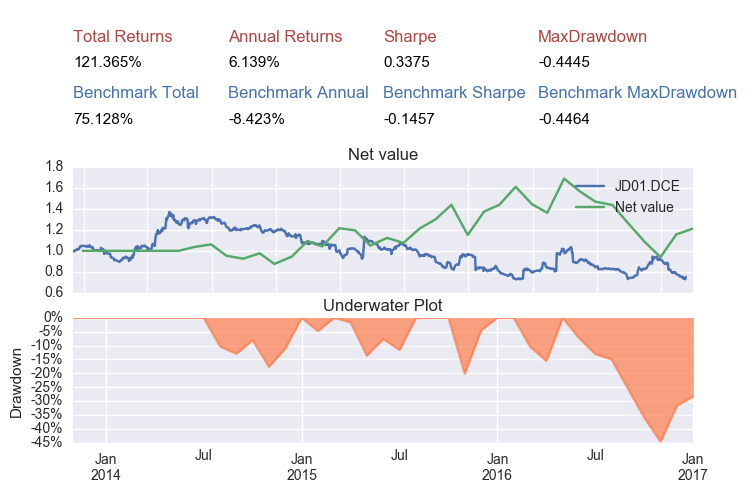

In [458]:
f, (ax1, ax2, ax3) = plt.subplots(3)
ax1.axis('off')
for x, y1, y2, label, value, label_color, value_color in fig_data:
    ax1.text(x, y1, label, color=label_color, fontsize=font_size)
    ax1.text(x, y2, value, color=value_color, fontsize=value_font_size)
ax2.set_title("Net value")
ax2.set_xticklabels('')
ax2.plot((1 + raw_df["value"]).index, (1 + raw_df["value"]).cumprod(), label=contract)
ax2.plot((1 + df["pnl"]).index, (1 + df["pnl"]).cumprod(), label='Net value')
ax2.legend()
ax3 = pf.plot_drawdown_underwater(df["pnl"])

In [149]:
df = pd.read_csv("../data/contract_stats.csv")

In [150]:
df.head()

,Contract,Max Drawdown,Sharpe
0,A01.DCE,-0.890390,0.108633
1,AF01-S.CFE,0.000000,NaN
2,AG01.SHF,-0.477849,0.032210
3,AL01.SHF,-0.827220,0.380301
4,AU01.SHF,-0.588909,0.198452


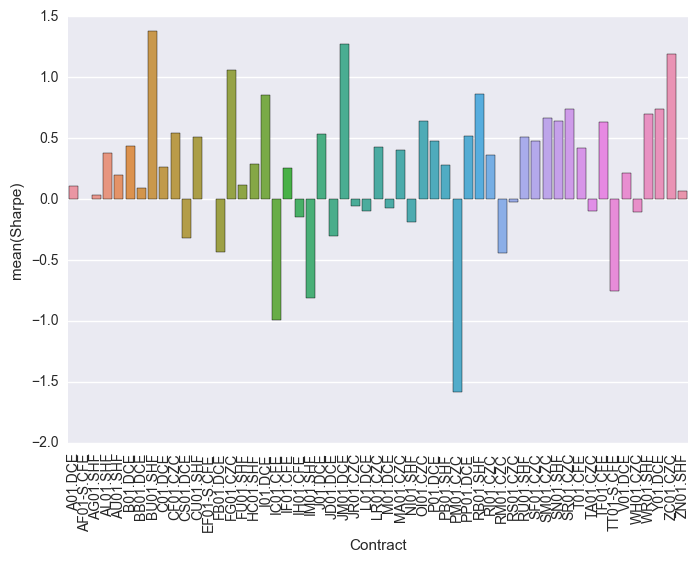

In [151]:
g = sns.barplot(x="Contract", y="Sharpe", data=df)
for item in g.get_xticklabels():
    item.set_rotation(90)